In [1]:
##################################################################################
#                                                                                #
#                                Comparison Notebook                             #
#                                                                                #
##################################################################################

In [2]:
# =====================
# Imports
# =====================
# %load_ext line_profiler
import sys
sys.path.append('..')
sys.path.append('mister_ed') # library for adversarial examples
sys.path.append('CertifiedReLURobustness')
from collections import defaultdict
import geocert_oop as geo
from domains import Domain
from plnn import PLNN
import _polytope_ as _poly_
from _polytope_ import Polytope, Face
import utilities as utils
import os
import time 
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from cvxopt import solvers, matrix
import adversarial_perturbations as ap 
import prebuilt_loss_functions as plf
import loss_functions as lf 
import adversarial_attacks as aa
import utils.pytorch_utils as me_utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import mnist.mnist_loader as  ml 
MNIST_DIM = 784

/home/justin/.conda/envs/DeepL/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [3]:
##################################################################################
#                                                                                #
#                       Network Model + Data Loading                             #
#                                                                                #
##################################################################################

# Define functions to train and evaluate a network 

def l1_loss(net):
    return sum([_.norm(p=1) for _ in net.parameters() if _.dim() > 1])

def l2_loss(net):
    return sum([_.norm(p=2) for _ in net.parameters() if _.dim() > 1])
  
    
def train(net, trainset, num_epochs):
    opt = optim.Adam(net.parameters(), lr=1e-3, weight_decay=0)
    for epoch in range(num_epochs):
        err_acc = 0
        err_count = 0
        for data, labels in trainset:
            output = net(Variable(data.view(-1, 784)))
            l = nn.CrossEntropyLoss()(output, Variable(labels)).view([1])
            l1_scale = torch.Tensor([2e-3])
            l += l1_scale * l1_loss(net).view([1])
            
            err_acc += (output.max(1)[1].data != labels).float().mean() 
            err_count += 1
            opt.zero_grad() 
            (l).backward() 
            opt.step() 
        print("(%02d) error:" % epoch, err_acc / err_count)
            
        
def test_acc(net, valset):
    err_acc = 0 
    err_count = 0 
    for data, labels in valset:
        n = data.shape[0]
        output = net(Variable(data.view(-1, 784)))
        err_acc += (output.max(1)[1].data != labels).float().mean() * n
        err_count += n
        
    print("Accuracy of: %.03f" % (1 - (err_acc / err_count).item()))

In [4]:
# Set Testing Parameters
ALL_DIGITS = True 
lp_norm = 'l_2'
train_network = False

if not ALL_DIGITS:
    digits = [1, 7]
    trainset = ml.load_single_digits('train', digits, batch_size=16, 
                                      shuffle=False)  
    valset = ml.load_single_digits('val', digits, batch_size=16, 
                                      shuffle=False)
    NETWORK_NAME = '17_mnist_small.pkl'
    layer_sizes = [MNIST_DIM, 10, 50, 10, len(digits)]
    if lp_norm == 'l_inf':
        pgd_lr = 0.01
    elif lp_norm == 'l_2':
        pgd_lr = 0.005
    num_epochs = 50
    num_pgd_iterations = 300
else:    
    trainset = ml.load_mnist_data('train', batch_size=16, shuffle=False)
    valset = ml.load_mnist_data('val', batch_size=16, shuffle=False)
    NETWORK_NAME = 'mnist_small.pkl'
    layer_sizes = [MNIST_DIM, 10, 50, 10, 10]
    num_pgd_iterations = 300
    if lp_norm == 'l_inf':
        pgd_lr = 0.01
    elif lp_norm == 'l_2':
        pgd_lr = 0.005
    num_epochs = 100


if train_network:
    
    print("Training a new network")
    network = PLNN(layer_sizes)
    net = network.net
    train(net, trainset, num_epochs)
    pickle.dump(network, open(NETWORK_NAME, 'wb'))
else:    
    network = pickle.load(open(NETWORK_NAME, 'rb'))
    net = network.net
    print("Loaded pretrained network")


    
test_acc(net, valset)    

Loaded pretrained network
Accuracy of: 0.886


In [5]:
# =====================
# Set Images to Verify
# =====================
num_batches = len(valset)
num_batches = 30

if not ALL_DIGITS:
    images = torch.cat([batch_tuple[0] for batch_tuple in valset[0:num_batches]])
    labels = torch.cat([batch_tuple[1] for batch_tuple in valset[0:num_batches]])
else:
    images = torch.cat([next(iter(valset))[0] for _ in range(0, num_batches)])
    labels = torch.cat([next(iter(valset))[1] for _ in range(0, num_batches)])
    
print('Num Images:', len(images))
# from CertifiedReLURobustness.Lip_Lin import run_Lip_Lin

Num Images: 480


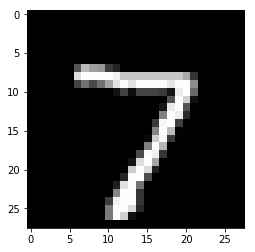

Starting upper bound computation
Upper bound of 2.2795445919036865 in 1.15 seconds
---Initial Polytope---
REJECT DICT:  {'dead_constraints': 65}
Pushed 8/5 facets
---Opening New Polytope---
Bounds  0.045420473196812396   |   0.9098876334275379
REJECT DICT:  {'dead_constraints': 65, 'seen before': 1}
Pushed 4/4 facets
---Opening New Polytope---
Bounds  0.268969948619791   |   0.9098876334275379
REJECT DICT:  {'dead_constraints': 65, 'seen before': 1}
Pushed 4/4 facets
---Opening New Polytope---
Bounds  0.27056933809512707   |   0.9098876334275379
REJECT DICT:  {'dead_constraints': 65, 'seen before': 2}
Pushed 3/3 facets
---Opening New Polytope---
Bounds  0.4035609541788999   |   0.9098876334275379
REJECT DICT:  {'dead_constraints': 65, 'seen before': 1}
Pushed 4/4 facets
---Opening New Polytope---
Bounds  0.4035627890098532   |   0.9098876334275379
REJECT DICT:  {'dead_constraints': 65, 'seen before': 2}
Pushed 3/3 facets
---Opening New Polytope---
Bounds  0.4535270198602852   |   0.909

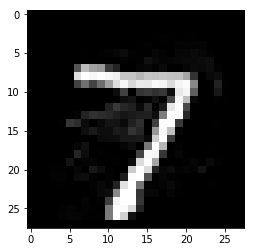

TIME 20.957935094833374


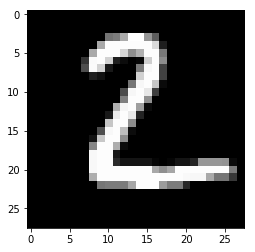

Starting upper bound computation
Upper bound of 0.034154754132032394 in 1.09 seconds
---Initial Polytope---
REJECT DICT:  {'dead_constraints': 70}
Pushed 1/0 facets
----------Minimal Projection Generated----------
DIST:  0.004678852908901078


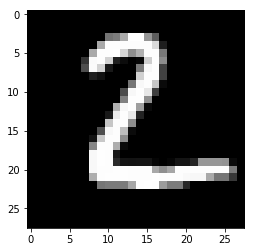

TIME 1.2587196826934814


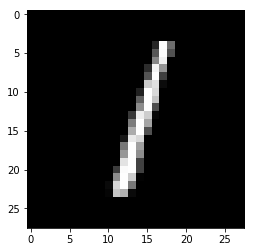

Starting upper bound computation
Upper bound of 1.9858143329620361 in 1.18 seconds
---Initial Polytope---
REJECT DICT:  {'dead_constraints': 62}
Pushed 7/8 facets
---Opening New Polytope---
Bounds  0.010403189238410524   |   1.9858143329620361
REJECT DICT:  {'dead_constraints': 62, 'seen before': 1}
Pushed 6/7 facets
---Opening New Polytope---
Bounds  0.04323370321777067   |   1.9858143329620361
REJECT DICT:  {'dead_constraints': 62, 'seen before': 1}
Pushed 6/7 facets
---Opening New Polytope---
Bounds  0.04591789081308989   |   1.9858143329620361
REJECT DICT:  {'dead_constraints': 62, 'seen before': 2}
Pushed 5/6 facets
---Opening New Polytope---
Bounds  0.08482423492450877   |   1.9858143329620361
REJECT DICT:  {'dead_constraints': 62, 'seen before': 1}
Pushed 8/7 facets
---Opening New Polytope---
Bounds  0.09534586284224071   |   0.8952349595539808
REJECT DICT:  {'dead_constraints': 62, 'seen before': 2}
Pushed 6/6 facets
---Opening New Polytope---
Bounds  0.10529073265900099   |   

Pushed 5/6 facets
---Opening New Polytope---
Bounds  0.5965465442989949   |   0.8952319640701505
REJECT DICT:  {'dead_constraints': 62, 'domain_infeasible': 2, 'seen before': 3}
Pushed 3/3 facets
---Opening New Polytope---
Bounds  0.5986515648315719   |   0.8952319640701505
REJECT DICT:  {'dead_constraints': 62, 'seen before': 3}
Pushed 4/5 facets
---Opening New Polytope---
Bounds  0.6016471946192675   |   0.8952319640701505
REJECT DICT:  {'dead_constraints': 62, 'domain_infeasible': 2, 'seen before': 4}
Pushed 2/2 facets
---Opening New Polytope---
Bounds  0.6140327282398539   |   0.8952319640701505
REJECT DICT:  {'dead_constraints': 62, 'seen before': 3}
Pushed 2/5 facets
---Opening New Polytope---
Bounds  0.6140335082829278   |   0.8952319640701505
REJECT DICT:  {'dead_constraints': 62, 'seen before': 4}
Pushed 1/4 facets
---Opening New Polytope---
Bounds  0.6140336700046632   |   0.8952319640701505
REJECT DICT:  {'dead_constraints': 62, 'seen before': 4}
Pushed 1/4 facets
---Opening

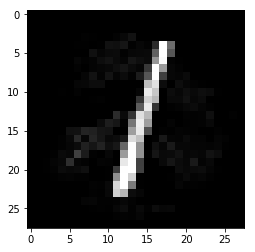

TIME 62.07070302963257


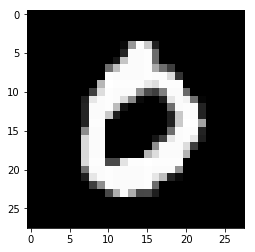

Starting upper bound computation
Upper bound of 5.272250652313232 in 1.18 seconds
---Initial Polytope---
REJECT DICT:  {'dead_constraints': 59, 'domain_infeasible': 3}
Pushed 9/8 facets
---Opening New Polytope---
Bounds  0.060476915653010783   |   2.440144750721885
REJECT DICT:  {'dead_constraints': 59, 'domain_infeasible': 3, 'seen before': 1}
Pushed 6/7 facets
---Opening New Polytope---
Bounds  0.17702427025405304   |   2.436629571177732
REJECT DICT:  {'dead_constraints': 59, 'domain_infeasible': 2, 'seen before': 1}
Pushed 9/8 facets
---Opening New Polytope---
Bounds  0.28250795960940756   |   2.1482373651552287
REJECT DICT:  {'dead_constraints': 59, 'domain_infeasible': 3, 'upper_bound': 1, 'seen before': 1}
Pushed 5/6 facets
---Opening New Polytope---
Bounds  0.28431276346668727   |   2.1482373651552287
REJECT DICT:  {'dead_constraints': 59, 'domain_infeasible': 3, 'upper_bound': 1, 'seen before': 2}


KeyboardInterrupt: 

In [6]:
##################################################################################
#                                                                                #
#                       Geocert                                                  #
#                                                                                #
##################################################################################



# Run Geocert on a set of mnist digits
min_dists = []
pgd_dists = []
num_polys = []
poly_maps = []
times = []
for image in images:
        # Builds an object used to to hold algorithm parameters
        cert_obj = geo.IncrementalGeoCert(network, verbose=True, config_fxn='parallel', 
                                  config_fxn_kwargs={'num_jobs': 1},
                                  hyperbox_bounds=[0.0, 1.0])
    
        plt.gray()
        plt.imshow(image.squeeze())
        plt.show()
        true_label = network(image).squeeze().max(0)[1].item()
        # Run Geocert 
        start = time.time()
        output = cert_obj.min_dist(image.view(1, -1), lp_norm=lp_norm, compute_upper_bound=
                                   {"optimizer_kwargs": {"lr": pgd_lr}, "num_iterations": num_pgd_iterations})
        lp_dist, adv_ex_bound, adv_ex, best_example, boundary_facet, seen_poly_map = output
        end = time.time()
        plt.gray()
        best_example_np = utils.as_numpy(best_example).reshape(28,28)
        plt.imshow(best_example_np.squeeze())
        plt.show()
        
        min_dists.append(lp_dist)
        pgd_dists.append(adv_ex_bound)
        print('TIME', end-start)
        times.append(end-start)
        num_polys.append(len(seen_poly_map))
        poly_maps.append(seen_poly_map)
        print('===========================================')

In [ ]:
# =====================
# Save Output
# =====================

output_dictionary = {'min_dists': min_dists , 'pgd_dists': pgd_dists, 'num_polys': num_polys,
                    'poly_maps': [list(_) for _ in poly_maps], 'times': times}

cwd = os.getcwd()
filename = cwd + "/Data/Geocert_out_"+str(NETWORK_NAME[0:-4])+"_"+lp_norm+".pkl"
f = open(filename, 'wb')
pickle.dump(output_dictionary, f)
f.close()

In [ ]:
# =====================
# Load and Display Output
# =====================

filename = cwd + "/Data/Geocert_out_"+str(NETWORK_NAME[0:-4])+"_"+lp_norm+".pkl"
cwd = os.getcwd()
f = open(filename,"rb")
output_dict = pickle.load(f)
f.close()

def mean(elements):
    return sum(elements) / float(len(elements))

def percentile(elements, perc=50):
    perc_idx = int(len(elements) * perc / 100.0)
    return sorted(elements)[perc_idx]


for k, v in output_dict.items():
    if k not in ['min_dists', 'pgd_dists', 'num_polys', 'times']:
        continue
    print('-' * 20, k, '-' * 20)
    print('MEAN   ', mean(v))
    print('25th   ', percentile(v, 25))
    print('MEDIAN ', percentile(v, 50))
    print('90     ', percentile(v, 90))
    print('\n')

In [ ]:
##################################################################################
#                                                                                #
#                       Fast Lin / Fast Lip                                      #
#                                                                                #
##################################################################################



In [ ]:
# =====================
# Load and Display Output
# =====================

cwd = os.getcwd()
filename = cwd + "/Data/Lip_Lin_" + str(NETWORK_NAME[0:-4]) + "_norm_" + '2' + ".pkl"
f = open(filename,"rb")
output_dict = pickle.load(f)
f.close()

def mean(elements):
    return sum(elements) / float(len(elements))

def percentile(elements, perc=50):
    perc_idx = int(len(elements) * perc / 100.0)
    return sorted(elements)[perc_idx]


for k, v in output_dict.items():
    if k not in ['min_dists', 'pgd_dists', 'num_polys', 'times']:
        continue
    print('-' * 20, k, '-' * 20)
    print('MEAN   ', mean(v))
    print('25th   ', percentile(v, 25))
    print('MEDIAN ', percentile(v, 50))
    print('90     ', percentile(v, 90))
    print('\n')